# Probabilistic Programming and Bayesian Methods for Hackers Chapter 1

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_TFP.ipynb"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_TFP.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

Original content ([this Jupyter notebook](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC2.ipynb)) created by Cam Davidson-Pilon ([`@Cmrn_DP`](https://twitter.com/Cmrn_DP))

Ported to [Tensorflow Probability](https://www.tensorflow.org/probability/) by Matthew McAteer ([`@MatthewMcAteer0`](https://twitter.com/MatthewMcAteer0)) and Bryan Seybold, with help from the TFP team at  Google ([`tfprobability@tensorflow.org`](mailto:tfprobability@tensorflow.org)).

Welcome to Bayesian Methods for Hackers. The full Github repository is available at [github/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers). The other chapters can be found on the project's [homepage](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/). We hope you enjoy the book, and we encourage any contributions!

---
### Table of Contents
- Dependencies & Prerequisites
- The Philosophy of Bayesian Inference
- The Bayesian state of mind
- Bayesian Inference in Practice
- Are frequentist methods incorrect then?
- Our Bayesian framework
- Example: Mandatory coin-flip example
- Example: Bug, or just sweet, unintended feature?
- Probability Distributions
  - Discrete Case
- Continuous Case
- But what is $\lambda \;$?
  - Example: Inferring behaviour from text-message data
- Introducing our first hammer: Tensorflow Probability
- specify the joint log-density
- Specify the posterior sampler
- Execute the TF graph to sample from the posterior
- Plot the Results
- Interpretation
- Exercises
- References

### Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>. 
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent nightly installation: <code>pip3 install -q tfp-nightly</code></li>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
    <li> For the most recent nightly GPU-connected version of TFP: <code>pip3 install -q tfp-nightly-gpu</code></li>
    </ul>
Again, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

In [1]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }
from __future__ import absolute_import, division, print_function

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass





#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
           tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

<module 'tensorflow_core._api.v2.config' from '/opt/conda/lib/python3.6/site-packages/tensorflow_core/_api/v2/config/__init__.py'>

## The Philosophy of Bayesian Inference

>You are a skilled programmer, but bugs still slip into your code. After a particularly difficult implementation of an algorithm, you decide to test your code on a trivial example. It passes. You test the code on a harder problem. It passes once again. And it passes the next, even more difficult, test too! You are starting to believe that there may be no bugs in this code...

If you think this way, then congratulations, you already are thinking Bayesian! Bayesian inference is simply updating your beliefs after considering new evidence. A Bayesian can rarely be certain about a result, but he or she can be very confident. Just like in the example above, we can never be 100% sure that our code is bug-free unless we test it on every possible problem; something rarely possible in practice. Instead, we can test it on a large number of problems, and if it succeeds we can feel more confident about our code, but still not certain. Bayesian inference works identically: we update our beliefs about an outcome; rarely can we be absolutely sure unless we rule out all other alternatives.



## The Bayesian state of mind
Bayesian inference differs from more traditional statistical inference by preserving uncertainty. At first, this sounds like a bad statistical technique. Isn't statistics all about deriving certainty from randomness? To reconcile this, we need to start thinking like Bayesians.

The Bayesian world-view interprets probability as measure of believability in an event, that is, how confident we are in an event occurring. In fact, we will see in a moment that this is the natural interpretation of probability.

For this to be clearer, we consider an alternative interpretation of probability: Frequentist, known as the more classical version of statistics, assume that probability is the long-run frequency of events (hence the bestowed title). For example, the probability of plane accidents under a frequentist philosophy is interpreted as the long-term frequency of plane accidents. This makes logical sense for many probabilities of events, but becomes more difficult to understand when events have no long-term frequency of occurrences. Consider: we often assign probabilities to outcomes of presidential elections, but the election itself only happens once! Frequentists get around this by invoking alternative realities and saying across all these realities, the frequency of occurrences defines the probability.

Bayesians, on the other hand, have a more intuitive approach. Bayesians interpret a probability as measure of belief, or confidence, of an event occurring. Simply, a probability is a summary of an opinion. An individual who assigns a belief of 0 to an event has no confidence that the event will occur; conversely, assigning a belief of 1 implies that the individual is absolutely certain of an event occurring. Beliefs between 0 and 1 allow for weightings of other outcomes. This definition agrees with the probability of a plane accident example, for having observed the frequency of plane accidents, an individual's belief should be equal to that frequency, excluding any outside information. Similarly, under this definition of probability being equal to beliefs, it is meaningful to speak about probabilities (beliefs) of presidential election outcomes: how confident are you candidate A will win?

Notice in the paragraph above, I assigned the belief (probability) measure to an individual, not to Nature. This is very interesting, as this definition leaves room for conflicting beliefs between individuals. Again, this is appropriate for what naturally occurs: different individuals have different beliefs of events occurring, because they possess different information about the world. The existence of different beliefs does not imply that anyone is wrong. Consider the following examples demonstrating the relationship between individual beliefs and probabilities:

* I flip a coin, and we both guess the result. We would both agree, assuming the coin is fair, that the probability of Heads is 1/2. Assume, then, that I peek at the coin. Now I know for certain what the result is: I assign probability 1.0 to either Heads or Tails (whichever it is). Now what is your belief that the coin is Heads? My knowledge of the outcome has not changed the coin's results. Thus we assign different probabilities to the result.

* Your code either has a bug in it or not, but we do not know for certain which is true, though we have a belief about the presence or absence of a bug.

* A medical patient is exhibiting symptoms *x*, *y* and *z*. There are a number of diseases that could be causing all of them, but only a single disease is present. A doctor has beliefs about which disease, but a second doctor may have slightly different beliefs.

This philosophy of treating beliefs as probability is natural to humans. We employ it constantly as we interact with the world and only see partial truths, but gather evidence to form beliefs. Alternatively, you have to be trained to think like a frequentist.

To align ourselves with traditional probability notation, we denote our belief about event $A$ as $P(A)$. We call this quantity the prior probability.

John Maynard Keynes, a great economist and thinker, said "When the facts change, I change my mind. What do you do, sir?" This quote reflects the way a Bayesian updates his or her beliefs after seeing evidence. Even — especially — if the evidence is counter to what was initially believed, the evidence cannot be ignored. We denote our updated belief as $P(A|X)$, interpreted as the probability of $A$ given the evidence $X$. We call the updated belief the posterior probability so as to contrast it with the prior probability. For example, consider the posterior probabilities (read: posterior beliefs) of the above examples, after observing some evidence $X$:


1. $P(A)$: the coin has a 50 percent chance of being Heads. $P(A|X)$: You look at the coin, observe a Heads has landed, denote this information  $X$, and trivially assign probability 1.0 to Heads and 0.0 to Tails.

2. $P(A)$: This big, complex code likely has a bug in it. $P(A|X)$: The code passed all $X$ tests; there still might be a bug, but its presence is less likely now.

3. $P(A)$: The patient could have any number of diseases. $P(A|X)$: Performing a blood test generated evidence $X$, ruling out some of the possible diseases from consideration.

It's clear that in each example we did not completely discard the prior belief after seeing new evidence $X$, but we re-weighted the prior to incorporate the new evidence (i.e. we put more weight, or confidence, on some beliefs versus others).

By introducing prior uncertainty about events, we are already admitting that any guess we make is potentially very wrong. After observing data, evidence, or other information, we update our beliefs, and our guess becomes less wrong. This is the alternative side of the prediction coin, where typically we try to be more right.






## Bayesian Inference in Practice
If frequentist and Bayesian inference were programming functions, with inputs being statistical problems, then the two would be different in what they return to the user. The frequentist inference function would return a number, representing an estimate (typically a summary statistic like the sample average etc.), whereas the Bayesian function would return probabilities.

For example, in our debugging problem above, calling the frequentist function with the argument "My code passed all $X$ tests; is my code bug-free?" would return a YES. On the other hand, asking our Bayesian function "Often my code has bugs. My code passed all $X$ tests; is my code bug-free?" would return something very different: probabilities of YES and NO. The function might return:

>YES, with probability 0.8; NO, with probability 0.2

This is very different from the answer the frequentist function returned. Notice that the Bayesian function accepted an additional argument: "Often my code has bugs". This parameter is the prior. By including the prior parameter, we are telling the Bayesian function to include our belief about the situation. Technically this parameter in the Bayesian function is optional, but we will see excluding it has its own consequences.

### Incorporating evidence
As we acquire more and more instances of evidence, our prior belief is washed out by the new evidence. This is to be expected. For example, if your prior belief is something ridiculous, like "I expect the sun to explode today", and each day you are proved wrong, you would hope that any inference would correct you, or at least align your beliefs better. Bayesian inference will correct this belief.

Denote $N$ as the number of instances of evidence we possess. As we gather an infinite amount of evidence, say as $N→∞,$ our Bayesian results (often) align with frequentist results. Hence for large N, statistical inference is more or less objective. On the other hand, for small $N$, inference is much more unstable: frequentist estimates have more variance and larger confidence intervals. This is where Bayesian analysis excels. By introducing a prior, and returning probabilities (instead of a scalar estimate), we preserve the uncertainty that reflects the instability of statistical inference of a small N dataset.

One may think that for large $N$, one can be indifferent between the two techniques since they offer similar inference, and might lean towards the computationally-simpler, frequentist methods. An individual in this position should consider the following quote by Andrew Gelman (2005)[[1]](#scrollTo=nDdph0r1ABCn), before making such a decision:

Sample sizes are never large. If $N$, is too small to get a sufficiently-precise estimate, you need to get more data (or make more assumptions). But once $N$, is "large enough," you can start subdividing the data to learn more (for example, in a public opinion poll, once you have a good estimate for the entire country, you can estimate among men and women, northerners and southerners, different age groups, etc.). $N$, is never enough because if it were "enough" you'd already be on to the next problem for which you need more data.



## Are frequentist methods incorrect then?
No.

Frequentist methods are still useful or state-of-the-art in many areas. Tools such as least squares linear regression, LASSO regression, and expectation-maximization algorithms are all powerful and fast. Bayesian methods complement these techniques by solving problems that these approaches cannot, or by illuminating the underlying system with more flexible modeling.

### A note on *Big Data*
Paradoxically, big data's predictive analytic problems are actually solved by relatively simple algorithms [[2]](#scrollTo=nDdph0r1ABCn)[[3]](#scrollTo=nDdph0r1ABCn). Thus we can argue that big data's prediction difficulty does not lie in the algorithm used, but instead on the computational difficulties of storage and execution on big data. (One should also consider Gelman's quote from above and ask "Do I really have big data?")

The much more difficult analytic problems involve medium data and, especially troublesome, really small data. Using a similar argument as Gelman's above, if big data problems are big enough to be readily solved, then we should be more interested in the not-quite-big enough datasets.

## Our Bayesian framework
We are interested in beliefs, which can be interpreted as probabilities by thinking Bayesian. We have a prior belief in event A, beliefs formed by previous information, e.g., our prior belief about bugs being in our code before performing tests.

Secondly, we observe our evidence. To continue our buggy-code example: if our code passes X tests, we want to update our belief to incorporate this. We call this new belief the posterior probability. Updating our belief is done via the following equation, known as Bayes' Theorem, after its discoverer Thomas Bayes:

$$ P(A|X) = \frac{P(X | A) P(A) }{P(X) } $$

$$ P(A|X) \propto{P(X | A) P(A) } $$

NOTE: ($\propto$ is "proportional to")


The above formula is not unique to Bayesian inference: it is a mathematical fact with uses outside Bayesian inference. Bayesian inference merely uses it to connect prior probabilities $P(A)$ with an updated posterior probabilities $P(A|X)$.


## Example: Mandatory coin-flip example
Every statistics text must contain a coin-flipping example, I'll use it here to get it out of the way. Suppose, naively, that you are unsure about the probability of heads in a coin flip (spoiler alert: it's 50%). You believe there is some true underlying ratio, call it p, but have no prior opinion on what p might be.

We begin to flip a coin, and record the observations: either H or T. This is our observed data. An interesting question to ask is how our inference changes as we observe more and more data? More specifically, what do our posterior probabilities look like when we have little data, versus when we have lots of data.

Below we plot a sequence of updating posterior probabilities as we observe increasing amounts of data (coin flips), while also demonstrating some of the best practices when it comes to evaluating tensors and plotting the data. First, the easy part: We define the values in our Tensorflow graph

In [2]:
# Build Graph
rv_coin_flip_prior = tfp.distributions.Bernoulli(probs=0.5, dtype=tf.int32)

num_trials = tf.constant([0,1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000])

coin_flip_data = rv_coin_flip_prior.sample(num_trials[-1])

# prepend a 0 onto tally of heads and tails, for zeroth flip
coin_flip_data = tf.pad(coin_flip_data,tf.constant([[1, 0,]]),"CONSTANT")

# compute cumulative headcounts from 0 to 2000 flips, and then grab them at each of num_trials intervals
cumulative_headcounts = tf.gather(tf.cumsum(coin_flip_data), num_trials)

rv_observed_heads = tfp.distributions.Beta(
    concentration1=tf.cast(1 + cumulative_headcounts, tf.float32),
    concentration0=tf.cast(1 + num_trials - cumulative_headcounts, tf.float32))

probs_of_heads = tf.linspace(start=0., stop=1., num=100, name="linspace")
observed_probs_heads = tf.transpose(rv_observed_heads.prob(probs_of_heads[:, tf.newaxis]))

Finally, we move onto plotting our tensors in matplotlib.

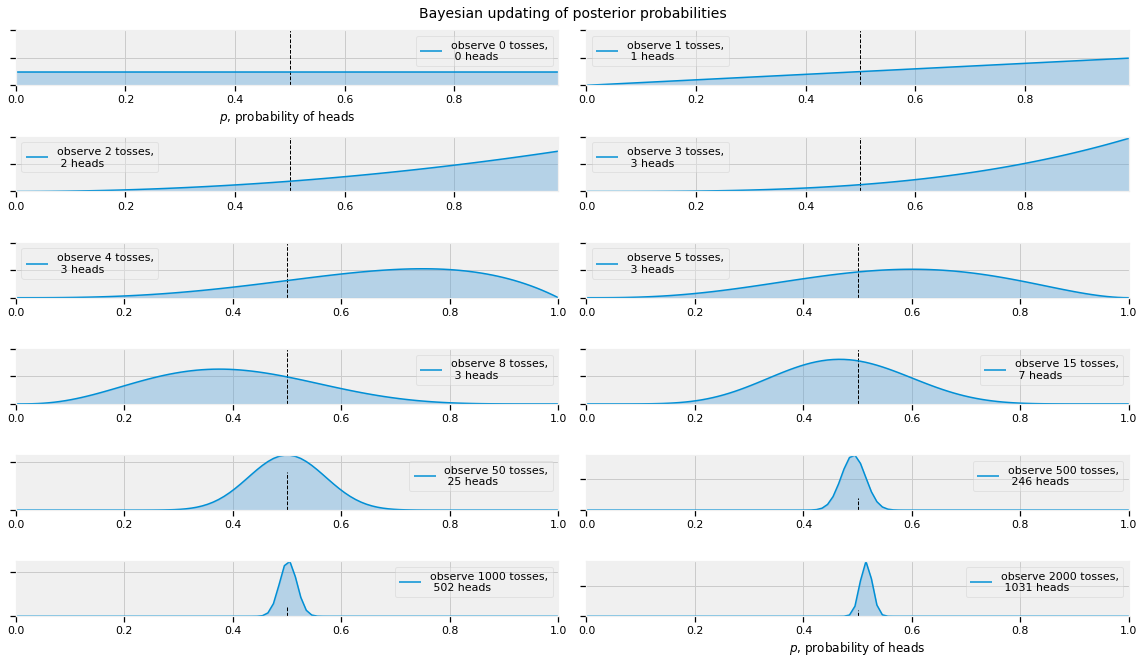

In [3]:
# For the already prepared, I'm using Binomial's conj. prior.
plt.figure(figsize(16, 9))
for i in range(len(num_trials)):
    sx = plt.subplot(len(num_trials)/2, 2, i+1)
    plt.xlabel("$p$, probability of heads") \
    if i in [0, len(num_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.plot(probs_of_heads, observed_probs_heads[i], 
             label="observe %d tosses,\n %d heads" % (num_trials[i], cumulative_headcounts[i]))
    plt.fill_between(probs_of_heads, 0, observed_probs_heads[i], 
                     color=TFColor[3], alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities", y=1.02,
             fontsize=14)
plt.tight_layout()

The posterior probabilities are represented by the curves, and our uncertainty is proportional to the width of the curve. As the plot above shows, as we start to observe data our posterior probabilities start to shift and move around. Eventually, as we observe more and more data (coin-flips), our probabilities will tighten closer and closer around the true value of $p=0.5$ (marked by a dashed line).

Notice that the plots are not always peaked at 0.5. There is no reason it should be: recall we assumed we did not have a prior opinion of what p is. In fact, if we observe quite extreme data, say 8 flips and only 1 observed heads, our distribution would look very biased away from lumping around 0.5 (with no prior opinion, how confident would you feel betting on a fair coin after observing 8 tails and 1 head?). As more data accumulates, we would see more and more probability being assigned at $p=0.5$, though never all of it.

The next example is a simple demonstration of the mathematics of Bayesian inference.

## Example: Bug, or just sweet, unintended feature?
Let $A$ denote the event that our code has no bugs in it. Let $X$ denote the event that the code passes all debugging tests. For now, we will leave the prior probability of no bugs as a variable, i.e. $P(A)=p$.

We are interested in $P(A|X)$, i.e. the probability of no bugs, given our debugging tests $X$. To use the formula above, we need to compute some quantities.

What is $P(X|A)$, i.e., the probability that the code passes $X$ tests given there are no bugs? Well, it is equal to 1, for a code with no bugs will pass all tests.

$P(X)$ is a little bit trickier: The event $X$ can be divided into two possibilities, event X occurring even though our code indeed has bugs (denoted $∼A$, spoken not $A$), or event $X$ without bugs $(A)$. $ P(X)$ can be represented as:

$$ \begin{align*}
P(A|X) &= \frac{P(X | A) P(A) }{P(X) } \\
 P(X) &= P(X \text{ and } A) + P(X \text{ and } \sim A) \\
  &= P(X|A)P(A) + P(X | \sim A)P(\sim A) \\
  &= P(X|A)p + P(X | \sim A)(1-p) \end{align*} $$


We have already computed $P(X|A)$ above. On the other hand, $P(X|\sim A)$ is subjective: our code can pass tests but still have a bug in it, though the probability there is a bug present is reduced. Note this is dependent on the number of tests performed, the degree of complication in the tests, etc. Let's be conservative and assign $P(X|\sim A)=0.5$. Then:

$$ \begin{align*}
P(A | X) &= \frac{1\cdot p}{ 1\cdot p +0.5 (1-p) } \\
&= \frac{ 2 p}{1+p} \end{align*} $$

This is the posterior probability. What does it look like as a function of our prior, $p\in[0,1]$?

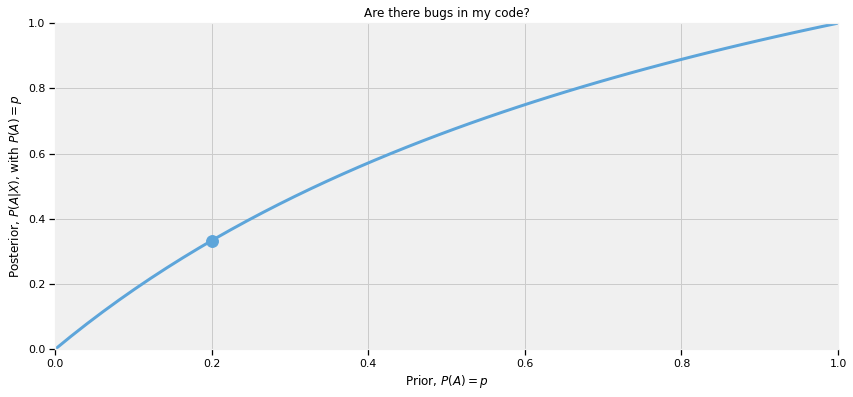

In [4]:
# Defining our range of probabilities
p = tf.linspace(start=0., stop=1., num=50)

# Visualization.
plt.figure(figsize=(12.5, 6))
plt.plot(p, 2*p/(1+p), color=TFColor[3], lw=3)
#plt.fill_between(p, 2*p/(1+p), alpha=.5, facecolor=["#A60628"])
plt.scatter(0.2, 2*(0.2)/1.2, s=140, c=TFColor[3])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r"Prior, $P(A) = p$")
plt.ylabel(r"Posterior, $P(A|X)$, with $P(A) = p$")
plt.title(r"Are there bugs in my code?");

We can see the biggest gains if we observe the $X$ tests passed when the prior probability, $p$, is low. Let's settle on a specific value for the prior. I'm a strong programmer (I think), so I'm going to give myself a realistic prior of 0.20, that is, there is a 20% chance that I write code bug-free. To be more realistic, this prior should be a function of how complicated and large the code is, but let's pin it at 0.20. Then my updated belief that my code is bug-free is 0.33.

Recall that the prior is a probability: $p$ is the prior probability that there are no bugs, so $1 \text{-} p$ is the prior probability that there are bugs.

Similarly, our posterior is also a probability, with $P(A|X)$ the probability there is no bug given we saw all tests pass, hence $1 \text{-} P(A|X)$ is the probability there is a bug given all tests passed. What does our posterior probability look like? Below is a chart of both the prior and the posterior probabilities.

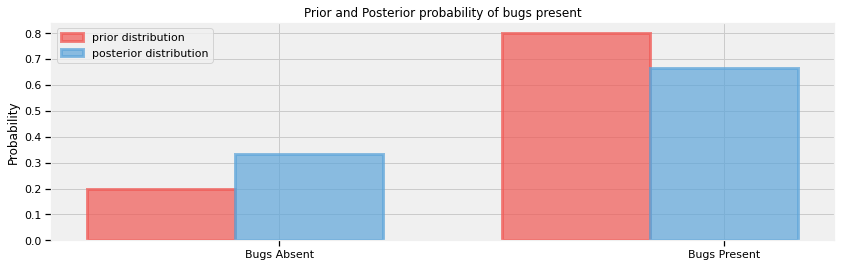

In [5]:
# Defining our priors and posteriors
prior = tf.constant([0.20, 0.80])
posterior = tf.constant([1./3, 2./3])

# Our Simple Visualization
plt.figure(figsize=(12.5, 4))
colours = [TFColor[0], TFColor[3]]
plt.bar([0, .7], prior, alpha=0.70, width=0.25,
        color=colours[0], label="prior distribution",
        lw="3", edgecolor=colours[0])
plt.bar([0+0.25, .7+0.25], posterior, alpha=0.7,
        width=0.25, color=colours[1],
        label=r"posterior distribution",
        lw="3", edgecolor=colours[1])

plt.xticks([0.20, .95], ["Bugs Absent", "Bugs Present"])
plt.title(r"Prior and Posterior probability of bugs present")
plt.ylabel("Probability")
plt.legend(loc="upper left");

Notice that after we observed $X$ occur, the probability of bugs being absent increased. By increasing the number of tests, we can approach confidence (probability 1) that there are no bugs present.

This was a very simple example of Bayesian inference and Bayes rule. Unfortunately, the mathematics necessary to perform more complicated Bayesian inference only becomes more difficult, except for artificially constructed cases. We will later see that this type of mathematical analysis is actually unnecessary. First we must broaden our modeling tools. The next section deals with probability distributions. If you are already familiar, feel free to skip (or at least skim), but for the less familiar the next section is essential.

## Probability Distributions
Let's quickly recall what a probability distribution is: Let $Z$ be some random variable. Then associated with $Z$ is a probability distribution function that assigns probabilities to the different outcomes $Z$ can take. Graphically, a probability distribution is a curve where the probability of an outcome is proportional to the height of the curve. You can see examples in the first figure of this chapter.

We can divide random variables into three classifications:

*  $Z$ is discrete: Discrete random variables may only assume values on a specified list. Things like populations, movie ratings, and number of votes are all discrete random variables. Discrete random variables become more clear when we contrast them with...

* $Z$ is continuous: Continuous random variable can take on arbitrarily exact values. For example, temperature, speed, time, color are all modeled as continuous variables because you can progressively make the values more and more precise.

* $Z$ is mixed: Mixed random variables assign probabilities to both discrete and continuous random variables, i.e. it is a combination of the above two categories.




### Discrete Case

If $Z$ is discrete, then its distribution is called a *probability mass function*, which measures the probability $Z$ takes on the value $k$, denoted $P(Z=k)$. Note that the probability mass function completely describes the random variable $Z$, that is, if we know the mass function, we know how $Z$ should behave. There are popular probability mass functions that consistently appear: we will introduce them as needed, but let's introduce the first very useful probability mass function. We say $Z$ is *Poisson*-distributed if:
 
$$P(Z = k) =\frac{ \lambda^k e^{-\lambda} }{k!}, \; \; k=0,1,2, \dots $$


$\lambda$ is called a parameter of the distribution, and it controls the distribution's shape. For the Poisson distribution, $\lambda$ can be any positive number. By increasing $\lambda$, we add more probability to larger values, and conversely by decreasing $\lambda$ we add more probability to smaller values. One can describe $\lambda$ as the *intensity* of the Poisson distribution. 

Unlike $\lambda$, which can be any positive number, the value $k$ in the above formula must be a non-negative integer, i.e., $k$ must take on values 0,1,2, and so on. This is very important, because if you wanted to model a population you could not make sense of populations with 4.25 or 5.612 members. 


If a random variable $Z$ has a Poisson mass distribution, we denote this by writing
 
$$Z \sim \text{Poi}(\lambda) $$
 
One useful property of the Poisson distribution is that its expected value is equal to its parameter, i.e.:

$$E\large[ \;Z\; | \; \lambda \;\large] = \lambda $$


We will use this property often, so it's useful to remember. Below, we plot the probability mass distribution for different $\lambda$ values. The first thing to notice is that by increasing $\lambda$, we add more probability of larger values occurring. Second, notice that although the graph ends at 15, the distributions do not. They assign positive probability to every non-negative integer.

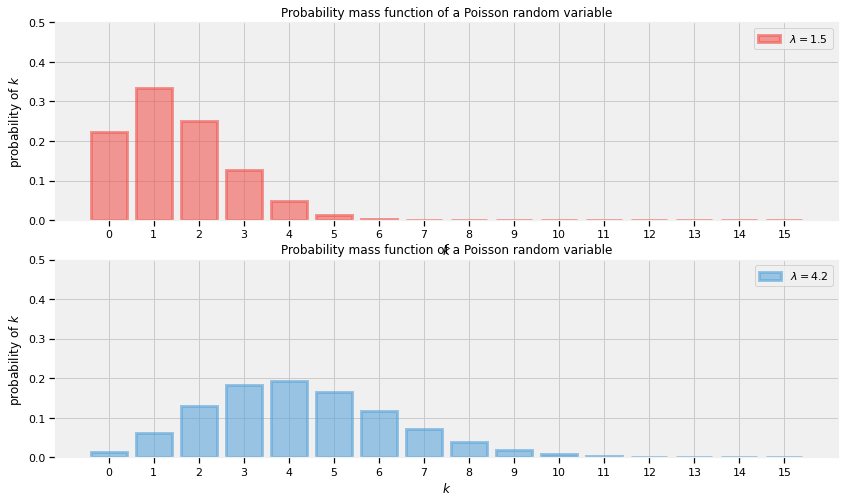

In [6]:
# Build graph.
x = tf.range (start=0., limit=16.,dtype=tf.float32)
lambdas = tf.constant([1.5, 4.25])

poi_pmf = tfd.Poisson(
  rate=lambdas[:, tf.newaxis]).prob(x)

plt.figure(figsize=(12.5, 8))

# Display results in two different histograms, for easier comparison
colours = [TFColor[0], TFColor[3]]
for i in [0,1]:
  ax = plt.subplot(2,1,i+1)
  ax.set_autoscaley_on(False)
  plt.title("Probability mass function of a Poisson random variable");

  plt.bar(x,
          poi_pmf[i],
          color=colours[i],
          label=r"$\lambda = %.1f$" % lambdas[i], alpha=0.60,
          edgecolor=colours[i], lw="3")
  plt.xticks(x)
  plt.ylim([0, .5])
  plt.legend()
  plt.ylabel(r"probability of $k$")
  plt.xlabel(r"$k$")

### Continuous Case

Instead of a probability mass function, a continuous random variable has a *probability density function*. This might seem like unnecessary nomenclature, but the density function and the mass function are very different creatures. An example of continuous random variable is a random variable with *exponential density*. The density function for an exponential random variable looks like this:

$$f_Z(z | \lambda) = \lambda e^{-\lambda z }, \;\; z\ge 0$$
 
Like a Poisson random variable, an exponential random variable can take on only non-negative values. But unlike a Poisson variable, the exponential can take on *any* non-negative values, including non-integral values such as 4.25 or 5.612401. This property makes it a poor choice for count data, which must be an integer, but a great choice for time data, temperature data (measured in Kelvins, of course), or any other precise *and positive* variable. The graph below shows two probability density functions with different $\lambda$ values. 

When a random variable $Z$ has an exponential distribution with parameter $\lambda$, we say *$Z$ is exponential* and write

$$Z \sim \text{Exp}(\lambda)$$
 
Given a specific $\lambda$, the expected value of an exponential random variable is equal to the inverse of $\lambda$, that is:

$$E[\; Z \;|\; \lambda \;] = \frac{1}{\lambda}$$

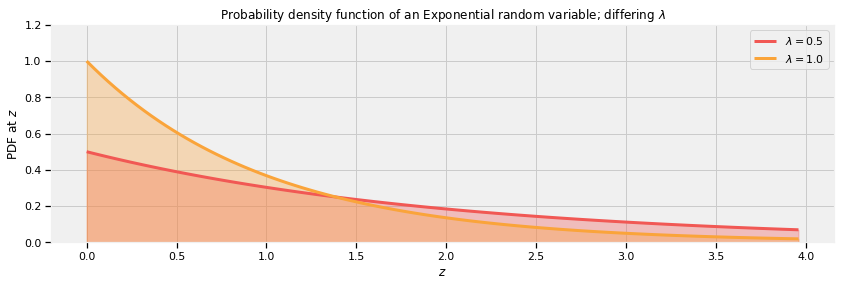

In [7]:
# Defining our Data and assumptions (use tf.linspace for continuous)
a = tf.range(start=0., limit=4., delta=0.04)
a = a[..., tf.newaxis]
lambdas = tf.constant([0.5, 1.])

# Now we use TFP to compute probabilities in a vectorized manner.
expo_pdf = tfd.Exponential(rate=lambdas).prob(a)

# Visualizing our results
plt.figure(figsize=(12.5, 4))
for i in range(lambdas.shape[0]):
    plt.plot(tf.transpose(a)[0], tf.transpose(expo_pdf)[i],
             lw=3, color=TFColor[i], label=r"$\lambda = %.1f$" % lambdas[i])
    plt.fill_between(tf.transpose(a)[0], tf.transpose(expo_pdf)[i],
                         color=TFColor[i], alpha=.33)
plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title(r"Probability density function of an Exponential random variable; differing $\lambda$");


 
## But what is $\lambda \;$?

**This question is what motivates statistics**. In the real world, $\lambda$ is hidden from us. We see only $Z$, and must go backwards to try and determine $\lambda$. The problem is difficult because there is no one-to-one mapping from $Z$ to $\lambda$. Many different methods have been created to solve the problem of estimating $\lambda$, but since $\lambda$ is never actually observed, no one can say for certain which method is best! 

Bayesian inference is concerned with *beliefs* about what $\lambda$ might be. Rather than try to guess $\lambda$ exactly, we can only talk about what $\lambda$ is likely to be by assigning a probability distribution to $\lambda$.
 
This might seem odd at first. After all, $\lambda$ is fixed; it is not (necessarily) random! How can we assign probabilities to values of a non-random variable? Ah, we have fallen for our old, frequentist way of thinking. Recall that under Bayesian philosophy, we *can* assign probabilities if we interpret them as beliefs. And it is entirely acceptable to have *beliefs* about the parameter $\lambda$. 


 
#### Example: Inferring behaviour from text-message data
 
Let's try to model a more interesting example, one that concerns the rate at which a user sends and receives text messages:

>  You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this? (This is in fact my own text-message data. Judge my popularity as you wish.)



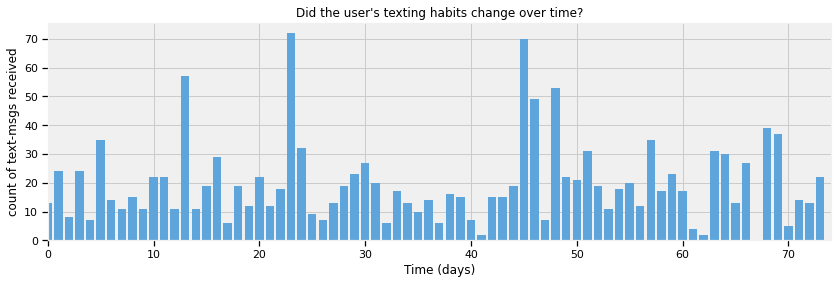

In [8]:
# Defining our Data and assumptions
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)
n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0],dtype=tf.int32)

# Visualizing the Results
plt.figure(figsize=(12.5, 4))
plt.bar(days.numpy(), count_data, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data[0].numpy());


Before we start modeling, see what you can figure out just by looking at the chart above. Would you say there was a change in behaviour during this time period? 
 
How can we start to model this? Well, as we have conveniently already seen, a Poisson random variable is a very appropriate model for this type of *count* data. Denoting day $i$'s text-message count by $C_i$, 
 
$$ C_i \sim \text{Poisson}(\lambda)  $$
 
We are not sure what the value of the $\lambda$ parameter really is, however. Looking at the chart above, it appears that the rate might become higher late in the observation period, which is equivalent to saying that $\lambda$ increases at some point during the observations. (Recall that a higher value of $\lambda$ assigns more probability to larger outcomes. That is, there is a higher probability of many text messages having been sent on a given day.)
 
How can we represent this observation mathematically? Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a *switchpoint*:
 
$$\lambda = 
\begin{cases} \lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the *exponential* distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.
$$
\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}
$$
$\alpha$ is called a *hyper-parameter* or *parent variable*. In literal terms, it is a parameter that influences other parameters. Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice.  A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 
 
An alternative, and something I encourage the reader to try, would be to have two priors: one for each $\lambda_i$. Creating two exponential distributions with different $\alpha$ values reflects our prior belief that the rate changed at some point during the observations.
 
What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible day. This is equivalent to saying
$$
\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}
$$
So after all this, what does our overall prior distribution for the unknown variables look like? Frankly, *it doesn't matter*. What we should understand is that it's an ugly, complicated mess involving symbols only a mathematician could love. And things will only get uglier the more complicated our models become. Regardless, all we really care about is the posterior distribution.

We next turn to [TensorFlow Probability](https://tensorflow.org/probability), a Python library for performing Bayesian analysis that is undaunted by the mathematical monster we have created.

## Introducing our first hammer: TensorFlow Probability

TensorFlow Probability (TFP) is a Python library for programming Bayesian analysis. It is intended for data scientists, statisticians, machine learning practitioners, and scientists. Since it is built on the TensorFlow (TF) stack, it brings the runtime benefits of TF to Bayesian analysis. These include write-once run-many (ability to run your development model in production) and speedups via state-of-the-art hardware (GPUs and TPUs). 

Since TFP is relatively new, the TFP community is actively developing documentation, 
especially docs and examples that bridge the gap between beginner and hacker. One of this book's main goals is to solve that problem, and also to demonstrate why TFP is so cool.

We will model the problem above using TFP. This type of programming is called *probabilistic programming*, an unfortunate misnomer that invokes ideas of randomly-generated code and has likely confused and frightened users away from this field. The code is not random; it is probabilistic in the sense that we create probability models using programming variables as the model's components. 

B. Cronin [[4]](#scrollTo=nDdph0r1ABCn) has a very motivating description of probabilistic programming:

>   Another way of thinking about this: unlike a traditional program, which only runs in the forward directions, a probabilistic program is run in both the forward and backward direction. It runs forward to compute the consequences of the assumptions it contains about the world (i.e., the model space it represents), but it also runs backward from the data to constrain the possible explanations. In practice, many probabilistic programming systems will cleverly interleave these forward and backward operations to efficiently home in on the best explanations.

Because of the confusion engendered by the term *probabilistic programming*, I'll refrain from using it. Instead, I'll simply say *programming*, since that's what it really is. 
 
TFP code is easy to read. The only novel thing should be the syntax. Simply remember that we are representing the model's components ($\tau, \lambda_1, \lambda_2$ ) as variables.

## Specify the joint log-density

We'll assume the data is a consequence of the following generative model:

$$\begin{align*}
\lambda_{1}^{(0)} &\sim \text{Exponential}(\text{rate}=\alpha) \\
\lambda_{2}^{(0)} &\sim \text{Exponential}(\text{rate}=\alpha) \\
\tau &\sim \text{Uniform}[\text{low}=0,\text{high}=1) \\
\text{for }  i &= 1\ldots N: \\
\lambda_i &= \begin{cases} \lambda_{1}^{(0)}, & \tau > i/N \\ \lambda_{2}^{(0)}, & \text{otherwise}\end{cases}\\
 X_i &\sim \text{Poisson}(\text{rate}=\lambda_i)
\end{align*}$$

Happily, this model can be easily implemented using TF and TFP's distributions:


This code creates a new function `lambda_`, but really we can think of it as a random variable: the random variable $\lambda$ from above. The [gather](https://https://www.tensorflow.org/api_docs/python/tf/gather) function assigns `lambda_1` or `lambda_2` as the value of `lambda_`, depending on what side of `tau` we are on. The values of `lambda_` up until `tau` are `lambda_1` and the values afterwards are `lambda_2`.

Note that because `lambda_1`, `lambda_2` and `tau` are random, `lambda_` will be random. We are **not** fixing any variables yet.

TFP performs probabilistic inference by evaluating the model parameters using a joint_log_prob function, which we'll describe more in Chapter 2.


In [9]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
 
    alpha = (1. / tf.reduce_mean(count_data))
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
 
    rv_tau = tfd.Uniform()
 
    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.cast(tau * tf.cast(tf.size(count_data), dtype=tf.float32) <= tf.cast(tf.range(tf.size(count_data)), dtype=tf.float32), dtype=tf.int32))
    rv_observation = tfd.Poisson(rate=lambda_)
 
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )


# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)


Notice that the implementation is arguably very close to being a 1:1 translation of the mathematical model. The main difference is merely that once we've specified the probabilistic model, we return the sum of the log_probs.

## Specify the posterior sampler

In [ ]:
# wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
  return tfp.mcmc.sample_chain(*args, **kwargs)

num_burnin_steps = 5000
num_results = 20000


# Set the chain's start state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

step_size = 0.2

kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))


# Sample from the chain.
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = graph_sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_chain_state,
    kernel = kernel)
    
tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data),dtype=tf.float32))

In [11]:
print("acceptance rate: {}".format(
    tf.reduce_mean(tf.cast(kernel_results.inner_results.inner_results.is_accepted,dtype=tf.float32))))
print("final step size: {}".format(
    tf.reduce_mean(kernel_results.inner_results.inner_results.accepted_results.step_size[-100:])))


acceptance rate: 0.5755000114440918
final step size: 0.030197443440556526


## Plot the Results

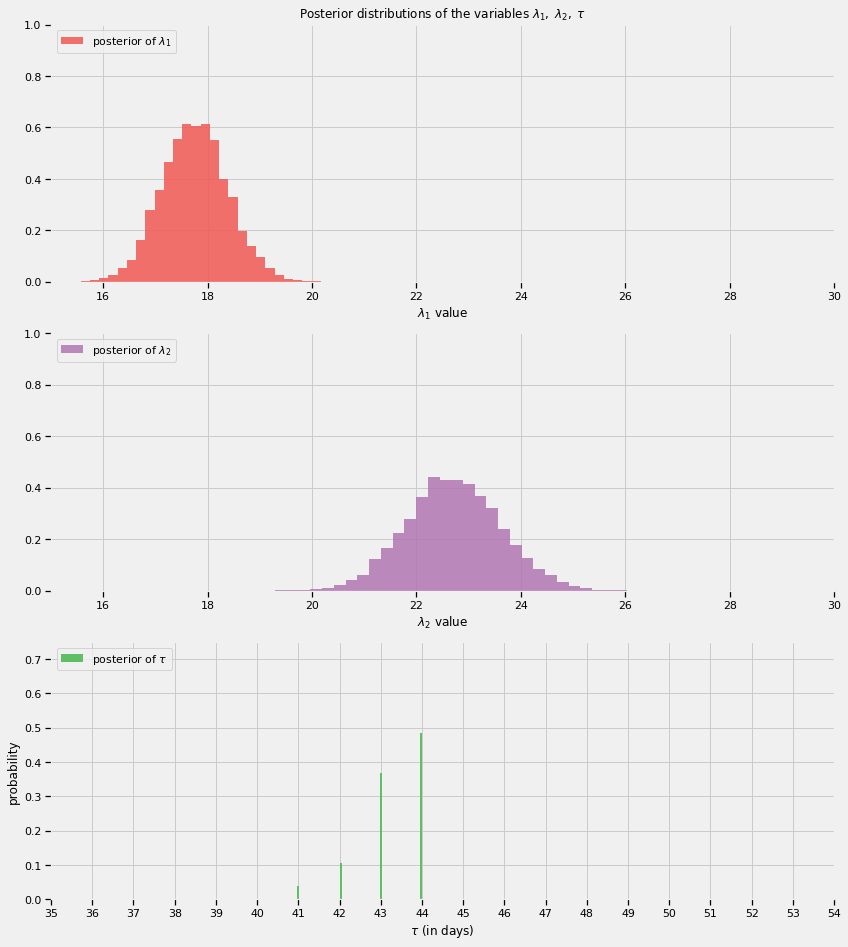

In [18]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color=TFColor[0], density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", color=TFColor[6], density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data[0], alpha=1,
         label=r"posterior of $\tau$",
         color=TFColor[2], weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data[0]))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability");

## Interpretation

Recall that Bayesian methodology returns a *distribution*. Hence we now have distributions to describe the unknown $\lambda$s and $\tau$. What have we gained? Immediately, we can see the uncertainty in our estimates: the wider the distribution, the less certain our posterior belief should be. We can also see what the plausible values for the parameters are: $\lambda_1$ is around 18 and $\lambda_2$ is around 23. The posterior distributions of the two $\lambda$s are clearly distinct, indicating that it is indeed likely that there was a change in the user's text-message behaviour.

What other observations can you make? If you look at the original data again, do these results seem reasonable? 

Notice also that the posterior distributions for the $\lambda$s do not look like exponential distributions, even though our priors for these variables were exponential. In fact, the posterior distributions are not really of any form that we recognize from the original model. But that's OK! This is one of the benefits of taking a computational point of view. If we had instead done this analysis using mathematical approaches, we would have been stuck with an analytically intractable (and messy) distribution. Our use of a computational approach makes us indifferent to mathematical tractability.
 
Our analysis also returned a distribution for $\tau$. Its posterior distribution looks a little different from the other two because it is a discrete random variable, so it doesn't assign probabilities to intervals. We can see that near day 45, there was a 50% chance that the user's behaviour changed. Had no change occurred, or had the change been gradual over time, the posterior distribution of $\tau$ would have been more spread out, reflecting that many days were plausible candidates for $\tau$. By contrast, in the actual results we see that only three or four days make any sense as potential transition points. 

### Why would I want samples from the posterior, anyways?

We will deal with this question for the remainder of the book, and it is an understatement to say that it will lead us to some amazing results. For now, let's end this chapter with one more example.

We'll use the posterior samples to answer the following question: what is the expected number of texts at day $t, \; 0 \le t \le 70$ ? Recall that the expected value of a Poisson variable is equal to its parameter $\lambda$. Therefore, the question is equivalent to *what is the expected value of $\lambda$ at time $t$*?
 
In the code below, let $i$ index samples from the posterior distributions. Given a day $t$, we average over all possible $\lambda_i$ for that day $t$, using $\lambda_i = \lambda_{1,i}$ if $t \lt \tau_i$ (that is, if the behaviour change has not yet occurred), else we use $\lambda_i = \lambda_{2,i}$. 


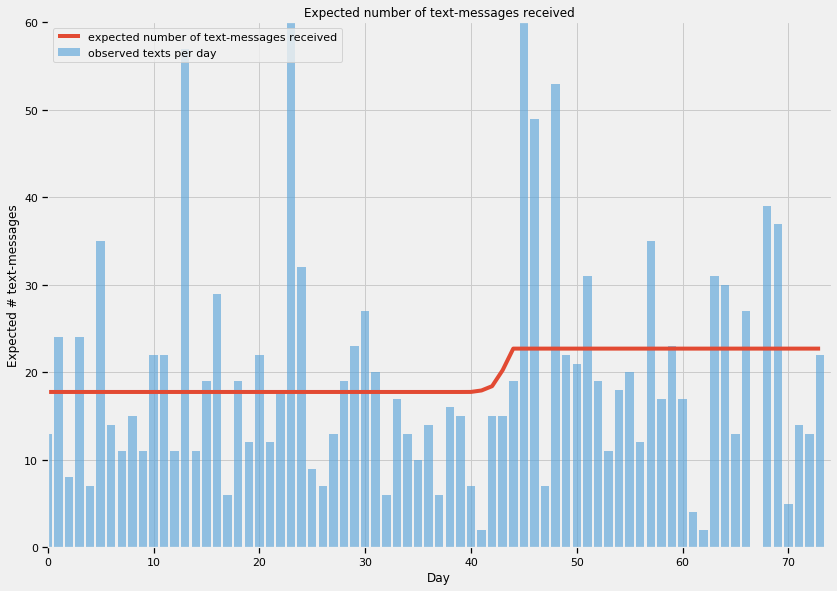

In [19]:
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution

N_ = tau_samples.shape[0]
expected_texts_per_day = tf.zeros(N_,n_count_data.shape[0]) #(10000,74)

plt.figure(figsize=(12.5, 9))

day_range = tf.range(0,n_count_data[0],delta=1,dtype = tf.int32)

# expand from shape of 74 to (10000,74)
day_range = tf.expand_dims(day_range,0)
day_range = tf.tile(day_range,tf.constant([N_,1]))

# expand from shape of 10000 to 10000,74
tau_samples_per_day = tf.expand_dims(tau_samples,0)
tau_samples_per_day = tf.transpose(tf.tile(tau_samples_per_day,tf.constant([day_range.shape[1],1])))

tau_samples_per_day = tf.cast(tau_samples_per_day,dtype=tf.int32)
#ix_day is (10000,74) tensor where axis=0 is number of samples, axis=1 is day. each value is true iff sampleXday value is < tau_sample value
ix_day = day_range < tau_samples_per_day

lambda_1_samples_per_day = tf.expand_dims(lambda_1_samples,0)
lambda_1_samples_per_day = tf.transpose(tf.tile(lambda_1_samples_per_day,tf.constant([day_range.shape[1],1])))
lambda_2_samples_per_day = tf.expand_dims(lambda_2_samples,0)
lambda_2_samples_per_day = tf.transpose(tf.tile(lambda_2_samples_per_day,tf.constant([day_range.shape[1],1])))

expected_texts_per_day = ((tf.reduce_sum(lambda_1_samples_per_day*tf.cast(ix_day,dtype=tf.float32),axis=0) + tf.reduce_sum(lambda_2_samples_per_day*tf.cast(~ix_day,dtype=tf.float32),axis=0))/N_)

plt.plot(range(n_count_data[0]), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data.numpy()[0])
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#5DA5DA", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

Our analysis shows strong support for believing the user's behavior did change ($\lambda_1$ would have been close in value to $\lambda_2$ had this not been true), and that the change was sudden rather than gradual (as demonstrated by $\tau$'s strongly peaked posterior distribution). We can speculate what might have caused this: a cheaper text-message rate, a recent weather-to-text subscription, or perhaps a new relationship. (In fact, the 45th day corresponds to Christmas, and I moved away to Toronto the next month, leaving a girlfriend behind.)


## Exercises
 
1.   Using `lambda_1_samples` and `lambda_2_samples`, what is the mean of the posterior distributions of $\lambda_1$ and $\lambda_2$?



In [0]:
#type your code here.

2.   What is the expected percentage increase in text-message rates? `hint:` compute the mean of `lambda_1_samples/lambda_2_samples`. Note that this quantity is very different from `lambda_1_samples.mean()/lambda_2_samples.mean()`

In [0]:
#type your code here.

3. What is the mean of $\lambda_1$ **given** that we know $\tau$ is less than 45? That is, suppose we have been given new information that the change in behaviour occurred prior to day 45. What is the expected value of $\lambda_1$ now? (You do not need to redo the TFP part. Just consider all instances where `tau_samples < 45`.)

In [0]:
#type your code here.

## References

[1] Gelman, Andrew. N.p.. Web. 22 Jan 2013. [N is never large enough](http://andrewgelman.com/2005/07/31/n_is_never_larg)
 
[2] Norvig, Peter. 2009. [The Unreasonable Effectiveness of Data](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/35179.pdf).

[3] Jimmy Lin and Alek Kolcz. Large-Scale Machine Learning at Twitter. Proceedings of the 2012 ACM SIGMOD International Conference on Management of Data (SIGMOD 2012), pages 793-804, May 2012, Scottsdale, Arizona.

[4] Cronin, Beau. "Why Probabilistic Programming Matters." 24 Mar 2013. Google, Online Posting to Google . Web. 24 Mar. 2013. <https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1>.